# Метрики модели,  переобучение.

## Задание: для данных из load_digits() построить несколько моделей и определить лучшую по метрике accuracy.

In [5]:
import pandas as  pd
import numpy as np
from sklearn.datasets import load_digits

In [53]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [7]:
data = load_digits()
data.keys()

dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])

X - матрица данных
y - столбец результатов, Ydummy - матрица результатов.

In [10]:
X = pd.DataFrame(data['data'])
y = pd.Series(data['target'])
Ydummy = pd.get_dummies(y)

### Простое дерево решений

Подбор параметров с помощью cross_validate и GridSearchCV показал оптимальные параметры для DecisionTreeClassifier:
* max_depth = 12; При этом значении max_depth график зависимости accuracy от max_depth выходит на "плато". 
* splitter = 'random'; причем при различных комбинациях max_depth, min_samples_leaf, max_features, 'random' дает чуть большую точность, чем 'best'

Перебор параметров min_samples_leaf  max_features в GridSearchCV  результатов не дал, установка параметров в значения, отличные от тех, что получаются в модели, приводит к уменьшению accuracy.

In [12]:
from sklearn.tree import DecisionTreeClassifier

In [76]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

In [16]:
cross_validate?

In [102]:
scores = cross_validate(DecisionTreeClassifier(max_depth=13,splitter='random',random_state=0), X, Ydummy,
                        cv=8, 
                        scoring='accuracy')

In [103]:
scores['test_score']

array([ 0.81777778,  0.88888889,  0.74666667,  0.81333333,  0.87555556,
        0.87053571,  0.83928571,  0.73214286])

In [105]:
scores['test_score'].mean()

0.82302331349206348

In [67]:
means = []
stds = []
for depth in range(1, 20):
    scores  = cross_val_score(DecisionTreeClassifier(max_depth = depth, splitter='random'),X, Ydummy, cv = 5, scoring='accuracy')
    means.append(scores.mean())
    stds.append(scores.std())

means_1 = []
stds_1 = []
for depth in range(1, 20):
    scores  = cross_val_score(DecisionTreeClassifier(max_depth = depth),X, Ydummy, cv = 5, scoring='accuracy')
    means_1.append(scores.mean())
    stds_1.append(scores.std())

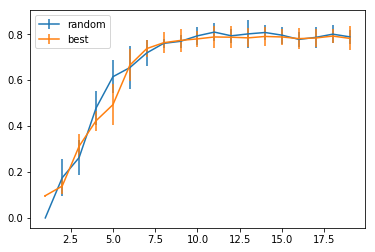

In [80]:
plt.errorbar(range(1, 20), means, stds);
plt.errorbar(range(1, 20), means_1, stds_1);
plt.legend(['random', 'best']);

In [56]:
from sklearn.model_selection import GridSearchCV

In [151]:
params = [{'max_depth': list(range(8,17)), 'splitter': ['best','random']}]

In [152]:
gs = GridSearchCV(DecisionTreeClassifier(random_state=0), param_grid = params, scoring='accuracy',cv=8,n_jobs=2);

In [153]:
gs.fit(X,Ydummy)

GridSearchCV(cv=8, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=2,
       param_grid=[{'max_depth': [8, 9, 10, 11, 12, 13, 14, 15, 16], 'splitter': ['best', 'random']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [154]:
gs.best_params_

{'max_depth': 16, 'splitter': 'random'}

In [155]:
gs.best_score_

0.82415136338341677

## Ансамбли: ExtraTrees, RandomForest

In [156]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier

In [205]:
scores = cross_validate(RandomForestClassifier(max_depth = 12, n_estimators=100, warm_start=True),
                        X, Ydummy,
                        cv = 8, n_jobs=2)

In [206]:
scores['test_score']

array([ 0.80444444,  0.90222222,  0.75111111,  0.81333333,  0.85333333,
        0.88839286,  0.84375   ,  0.77678571])

In [207]:
scores['test_score'].mean()

0.82917162698412694

In [157]:
params = [{'n_estimators': list(range(10,200,10))}]

In [ ]:
 Диапазон значений числа базовых деревьев
min_estimators = 15
max_estimators = 375

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1, 5):
        # Задаем число 
        clf.set_params(n_estimators=i)
        clf.fit(X, y)

        # Сохраняем результат
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))


In [189]:
gs = GridSearchCV(ExtraTreesClassifier(max_depth = 12, max_features='sqrt', bootstrap = True),
                    param_grid = params, cv=8, n_jobs=2)

In [190]:
gs.fit(X,Ydummy)

GridSearchCV(cv=8, error_score='raise',
       estimator=ExtraTreesClassifier(bootstrap=True, class_weight=None, criterion='gini',
           max_depth=12, max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=2,
       param_grid=[{'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [191]:
gs.best_score_

0.82860322760155813

In [195]:
gs.best_params_

{'n_estimators': 190}